In [4]:
using Plots; pyplot();
using DelimitedFiles, Distributions;
using AugmentedGaussianProcesses;

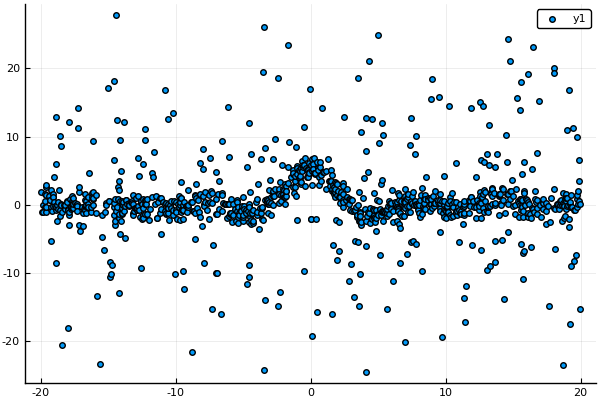

In [13]:
N = 1000
X = reshape((sort(rand(N)).-0.5).*40.0,N,1)
function latent(x)
    5.0.*sin.(x)./x
end
outliers = rand(N).>0.7
Y = (latent(X)+(1.0.-outliers).*rand(Normal(0,1),N)+outliers.*rand(Normal(0,10),N))[:];
scatter(X,Y)

In [28]:
# Run sparse classification with increasing number of inducing points
models = []
Ms = [4, 8, 16, 32, 64]
kernel = RBFKernel(1.0)
ν=10.0
for (index, num_inducing) in enumerate(Ms)
    m = SparseStudentT(X, Y, kernel=kernel,
        OptimizeIndPoints=true,Stochastic=false,Autotuning=false,m=num_inducing,ν=ν)
    println("Training with $(num_inducing) points")
    @time m.train(iterations=100)
    push!(models,m);
end

Training with 4 points
  0.009055 seconds (10.98 k allocations: 23.926 MiB, 50.04% gc time)
Training with 8 points
  0.012042 seconds (11.39 k allocations: 39.836 MiB, 39.78% gc time)
Training with 16 points
  0.025774 seconds (12.20 k allocations: 72.277 MiB, 18.62% gc time)
Training with 32 points
  0.054920 seconds (13.84 k allocations: 139.822 MiB, 17.26% gc time)
Training with 64 points
  0.128761 seconds (18.01 k allocations: 285.396 MiB, 13.83% gc time)


In [29]:
mfull = BatchStudentT(X, Y, kernel=kernel,Autotuning=true,ν=ν)
println("Training with full model")
@time mfull.train(iterations=5);
push!(models,mfull);

Training with full model
  0.732501 seconds (18.78 k allocations: 593.380 MiB, 25.01% gc time)


In [30]:
function compute_Grid(model,nGrid=50)
    mins = -20
    maxs = 20
    Xplot = collect(range(mins[1],stop=maxs[1],length=nGrid))
#     Xplot = hcat([j for i in xlin, j in ylin][:],[i for i in xlin, j in ylin][:])
    y = model.predictproba(Xplot)
    return (y,Xplot)
    end;

In [31]:
function plotdata(X,Y)
    plot(X,Y,t=:scatter,alpha=0.33,markerstrokewidth=0.0,lab="",size=(300,500));
end;

In [32]:
function plotcontour(model,X,Y)
    nGrid = 100
    (predic,x) = compute_Grid(model,nGrid);
    plotdata(X,Y)
    if in(:m,fieldnames(typeof(model)))
        plot!(model.inducingPoints[:,1],zero(model.inducingPoints[:,1]),msize=2.0,color="black",t=:scatter,lab="")
    end
    return plot!(x,predic,title=(in(:m,fieldnames(typeof(model))) ? "M = $(model.m)" : "full"),color="red",lab="",linewidth=3.0)
end;

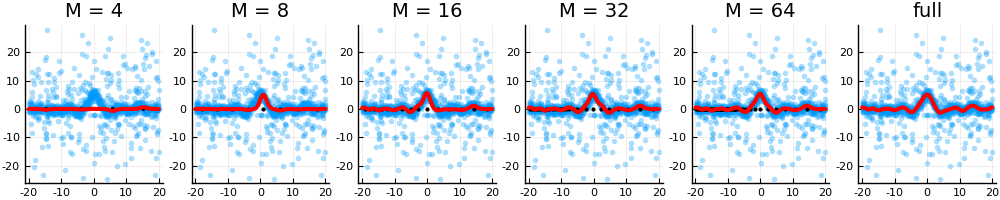

In [33]:
plot(broadcast(x->plotcontour(x,X,Y),models)...,layout=(1,length(models)),size=(1000,200))